In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from quality.analyze_types import create_typed_predictions, get_entity_node_degrees
sns.set()

In [3]:
embedding_approach = "BootEA"
dataset_name = "D_W_15K_V1"
kg1_ent_id_files = sorted([i for i in glob.iglob(f"../../output/results/{embedding_approach}/{dataset_name}/721_5fold/*/*/kg1_ent_ids")])
kg2_ent_id_files = sorted([i for i in glob.iglob(f"../../output/results/{embedding_approach}/{dataset_name}/721_5fold/*/*/kg2_ent_ids")])
pred_files = sorted([i for i in glob.iglob(f"../../data/output/results/{dataset_name}-721_5fold-*/{embedding_approach}/datasets/*/{dataset_name}-721_5fold-*_random forest 500_SimAndEmb_test_pred.csv")])
type_files = sorted([i for i in glob.iglob(f"../../data/OpenEA/typed_links/datasets/{dataset_name}/721_5fold/*/typed_test")])

In [4]:
df = create_typed_predictions(
    kg1_ent_id_files,
    kg2_ent_id_files,
    pred_files,
    type_files,
    f"../../data/OpenEA/typed_links/superclasses.json",
    1,
    False
)
false_negatives = df.loc[(df["pred"]==0) & (df["val"]==1)]
false_positives = df.loc[(df["pred"]==1) & (df["val"]==0)]

Enrich predictions: 100%|██████████| 21000/21000 [00:00<00:00, 111931.40it/s]


In [5]:
fp_type_counts = false_positives["left_types"].value_counts().to_frame().join(false_positives["right_types"].value_counts().to_frame())
fp_type_counts["types"] = fp_type_counts["left_types"] + fp_type_counts["right_types"]
fp_type_counts.drop(labels=["left_types","right_types"],axis=1,inplace=True)

In [6]:
entity_degrees = pd.Series(get_entity_node_degrees("../../data/OpenEA/D_W_15K_V1")).to_frame(name="node degree")

In [8]:
fp_col_name = "fp rate"
fn_col_name = "fn rate"
all_col_name = "rate of all"
fn_type_counts = false_negatives["left_types"].value_counts().to_frame()
df_left_types = ((df["left_types"].value_counts() + df["right_types"].value_counts())/2).to_frame(name="types")
tmp = df_left_types.join(fn_type_counts)
tmp = tmp.join(fp_type_counts, lsuffix="ALL", rsuffix="FP")
# get node degrees
df_with_nd = df.join(entity_degrees, on="left_uri").join(entity_degrees, on="right_uri", lsuffix=" left", rsuffix=" right")
avg_nd = ((df_with_nd.groupby(["left_types"])["node degree left"].mean() +
  df_with_nd.groupby(["right_types"])["node degree right"].mean())/2).sort_values(ascending=False).to_frame(name="avg node degree")
combined = tmp.join(avg_nd)
combined.reset_index(inplace=True)
combined = combined.rename(columns={"index":"Type","typesALL":all_col_name,"left_types":fn_col_name,"typesFP":fp_col_name})
combined["Type"] = [x.split('/')[-1].split('#')[-1] for x in combined["Type"].astype(str)]
#combined = combined_all[combined_all[all_col_name] >= 50].copy()
#combined = combined.iloc[:50]
#combined = combined_all
combined[fp_col_name] = (combined[fp_col_name]/combined[all_col_name])*100
combined[fn_col_name] = (combined[fn_col_name]/combined[all_col_name])*100
combined[all_col_name] = (combined[all_col_name]/combined[all_col_name].sum())*100
combined = combined.sort_values(by=all_col_name,ascending=False)
combined

,Type,rate of all,fn rate,fp rate,avg node degree
11,Film,31.781905,7.902071,0.020976,11.041446
18,Person,28.571905,12.933118,0.046666,18.425781
15,MusicalWork,15.257619,27.177679,0.012484,6.986466
13,Location,7.141429,14.136161,0.066680,17.497222
17,Organisation,6.620952,17.131761,NaN,15.343010
23,TelevisionEpisode,2.294286,19.468659,NaN,6.592948
20,Software,2.220952,25.214408,0.085763,6.494480
27,WrittenWork,1.784762,27.588047,0.106724,7.009568
24,TelevisionShow,1.720952,19.258439,NaN,26.410011
28,Thing,0.588095,35.627530,NaN,11.329555


In [ ]:
#sns.scatterplot(x="Average Node Degree",y="false negatives on this type",data=new_df)

In [ ]:
#sns.scatterplot(x="Average Node Degree",y="false positives on this type",data=new_df)

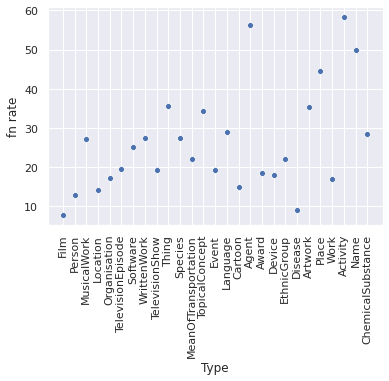

In [13]:
g = sns.scatterplot(x="Type",y="fn rate",data=combined)
for label in g.get_xticklabels():
    label.set_rotation(90)
g.get_figure().savefig("/tmp/test.png")

In [ ]:
ed = entity_degrees.copy()
ed.reset_index(inplace=True)
ed_left = ed.rename(columns={"index":"left_uri"})
ed_right = ed.rename(columns={"index":"right_uri"})
ed = ed_left.merge(df,on="left_uri")
ed = ed.merge(ed_right,on="right_uri",suffixes=[" left", " right"])
ed.loc[(ed["pred"]==0) & (ed["val"]==1),"error"] = "fn"
ed.loc[(ed["pred"]==1) & (ed["val"]==0),"error"] = "fp"
ed.dropna(subset=["error"], inplace=True)
ed.drop(labels=["pred","val"],axis=1,inplace=True)
ed

In [ ]:
g = sns.FacetGrid(ed, hue="error",dropna=False)
g.map(plt.scatter, "left_types", "right_types")